# Hello Image Segmentation

A very basic introduction to do image segmentation with OpenVINO model using Nano api.

This notebook comes from [003-hello-segmentation](https://github.com/openvinotoolkit/openvino_notebooks/tree/main/notebooks/003-hello-segmentation).

In this tutorial, a pre-trained [road-segmentation-adas-0001](https://docs.openvino.ai/latest/omz_models_model_road_segmentation_adas_0001.html) model from the [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/) is used. ADAS stands for Advanced Driver Assistance Services. The model recognizes four classes: background, road, curb and mark.

## Imports

In [7]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sys
from openvino.runtime import Core

## Load the Model

First, load the openvino model using `OpenVINOModel`.

`OpenVINOModel` accepts the xml model file path and compiles it to a OpenVINO model.

In [14]:
# Load the Model with Nano
from bigdl.nano.openvino import OpenVINOModel
ov_model = OpenVINOModel("model/road-segmentation-adas-0001.xml", device="CPU")


## Load an Image
A sample image from the [Mapillary Vistas](https://www.mapillary.com/dataset/vistas) dataset is provided. 

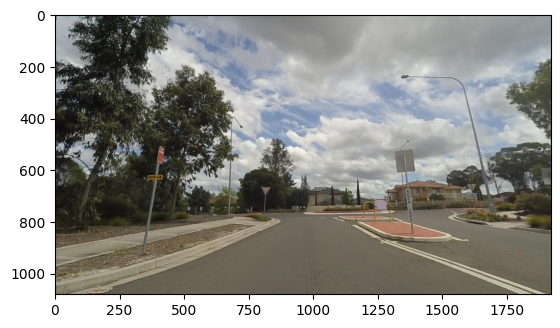

In [15]:
# The segmentation network expects images in BGR format.
image = cv2.imread("data/empty_road_mapillary.jpg")

rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_h, image_w, _ = image.shape

# get input and output array use ovmodel._compiled_model
ov_input_layer_ir = ov_model._compiled_model.input(0)
ov_output_layer_ir = ov_model._compiled_model.output(0)

# N,C,H,W = batch size, number of channels, height, width.
N, C, H, W = ov_input_layer_ir.shape

# OpenCV resize expects the destination size as (width, height).
resized_image = cv2.resize(image, (W, H))

# Reshape to the network input shape.
input_image = np.expand_dims(
    resized_image.transpose(2, 0, 1), 0
)  
plt.imshow(rgb_image)

## Do Inference
`OpenVINOModel` can be called directly to run inference, the return value is a dict of output name and output array.


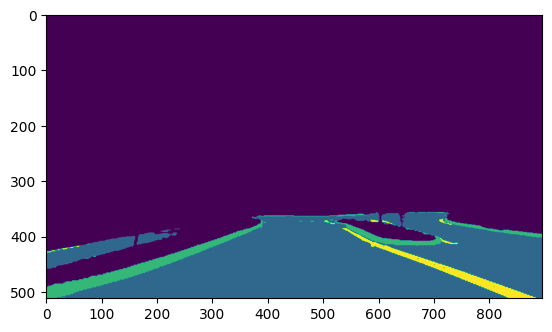

In [20]:
# Run the inference.

# pass the input data to `ov_model` and call it directly.
ov_result = ov_model(input_image)[ov_output_layer_ir]

# Prepare data for visualization.
ov_segmentation_mask = np.argmax(ov_result, axis=1)
plt.imshow(ov_segmentation_mask.transpose(1, 2, 0))

## Prepare Data for Visualization

In [17]:
# utility function to process network result.
def segmentation_map_to_image(
    result: np.ndarray, colormap: np.ndarray, remove_holes: bool = False
) -> np.ndarray:
    """
    Convert network result of floating point numbers to an RGB image with
    integer values from 0-255 by applying a colormap.

    :param result: A single network result after converting to pixel values in H,W or 1,H,W shape.
    :param colormap: A numpy array of shape (num_classes, 3) with an RGB value per class.
    :param remove_holes: If True, remove holes in the segmentation result.
    :return: An RGB image where each pixel is an int8 value according to colormap.
    """
    if len(result.shape) != 2 and result.shape[0] != 1:
        raise ValueError(
            f"Expected result with shape (H,W) or (1,H,W), got result with shape {result.shape}"
        )

    if len(np.unique(result)) > colormap.shape[0]:
        raise ValueError(
            f"Expected max {colormap[0]} classes in result, got {len(np.unique(result))} "
            "different output values. Please make sure to convert the network output to "
            "pixel values before calling this function."
        )
    elif result.shape[0] == 1:
        result = result.squeeze(0)

    result = result.astype(np.uint8)

    contour_mode = cv2.RETR_EXTERNAL if remove_holes else cv2.RETR_TREE
    mask = np.zeros((result.shape[0], result.shape[1], 3), dtype=np.uint8)
    for label_index, color in enumerate(colormap):
        label_index_map = result == label_index
        label_index_map = label_index_map.astype(np.uint8) * 255
        contours, hierarchies = cv2.findContours(
            label_index_map, contour_mode, cv2.CHAIN_APPROX_SIMPLE
        )
        cv2.drawContours(
            mask,
            contours,
            contourIdx=-1,
            color=color.tolist(),
            thickness=cv2.FILLED,
        )

    return mask

In [18]:
# Define colormap, each color represents a class.
colormap = np.array([[68, 1, 84], [48, 103, 141], [53, 183, 120], [199, 216, 52]])

# Define the transparency of the segmentation mask on the photo.
alpha = 0.3

# transform mask to an RGB image.
ov_mask = segmentation_map_to_image(ov_segmentation_mask, colormap)
ov_resized_mask = cv2.resize(ov_mask, (image_w, image_h))

# Create an image with mask.
ov_image_with_mask = cv2.addWeighted(ov_resized_mask, alpha, rgb_image, 1 - alpha, 0)

## Visualize data

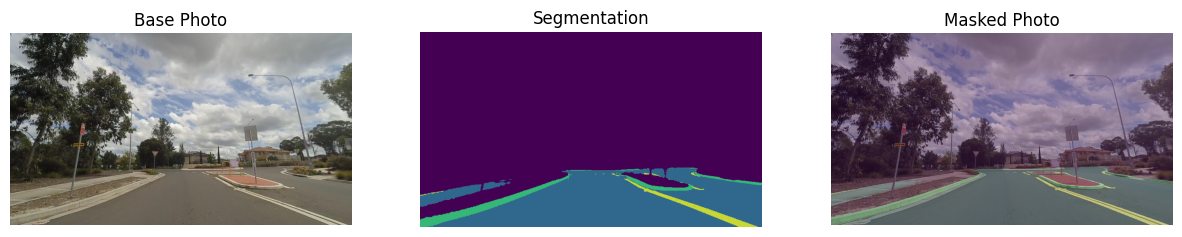

In [19]:
# Define titles with images.
data = {"Base Photo": rgb_image, "Segmentation": ov_mask, "Masked Photo": ov_image_with_mask}
# Create a subplot to visualize images.
fig, axs = plt.subplots(1, len(data.items()), figsize=(15, 10))

# Fill the subplot.
for ax, (name, image) in zip(axs, data.items()):
    ax.axis('off')
    ax.set_title(name)
    ax.imshow(image)

# Display an image.
plt.show(fig)